# Theory

The onedimensional Schrödinger Equation with a time independent Potential is:  
$i\hbar\frac{\partial\Psi(x,t)}{\partial t}=-\frac{\hbar^2}{2m}\frac{\partial^2\Psi(x,t)}{\partial x^2}+V(x)\Psi(x,t)$  
Using seperation of variables $\Psi(x,t)=\psi(x)\phi(t)$ we derive the following differential Equations:  
$\frac{d\phi}{dt}=-\frac{iE}{\hbar}\phi\rightarrow\phi(t)=e^{-\frac{iE}{\hbar}t}$  
and  
$-\frac{\hbar^2}{2m}\frac{d^2\psi}{dx^2}+V(x)\psi=E\psi$ or $\hat{H}\psi=E\psi$  
This program is going to solve the Eigenproblem of the time independent Schrödinger Equation numerically and in the end, multiply the time dependent part to get $\Psi(x,t)$. 

## Deriving the numerical solution

The first approximation to make is, that the Wave function is bounded in the region from $x=0$ to $x=L$, meaning $\psi(0)=\psi(L)=0$. This requirement is basically enforcing that the wave function stays normalizable, and for sufficiently large $L$, the wave function is approximately unbounded in between.  
To make things easier, we are going to introduce a dimensionless variable $\xi=\frac{x}{L}$. The boundary conditions become $\psi(0)=\psi(1)=0$ and the time independent Schrödinger Equation becomes $-\frac{\hbar^2}{2mL^2}\frac{d^2\psi}{d\xi^2}+V(\xi)\psi=E\psi$. (If you want you can rename it back to $x$ since that is the name I will use in the code.)  
The next approximation necessary is the discretization of the $\xi$ axis into $N$ intervalls of distance $\Delta\xi$. Since the wave function only exists between $\xi=0$ and $\xi=1$ we get $N\Delta\xi=1$

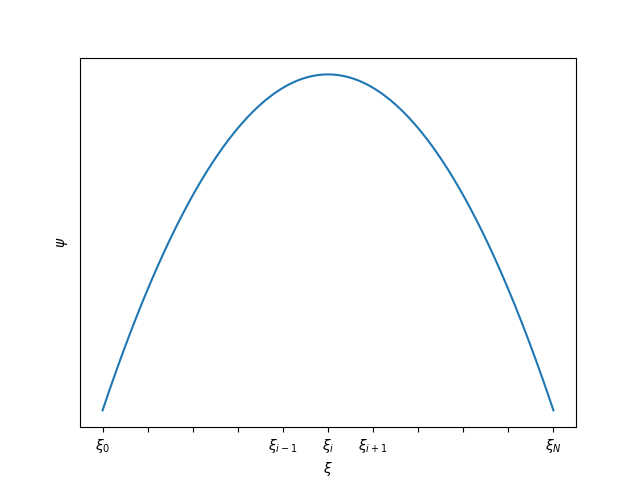

We are now approximating $\psi(\xi_i+\Delta\xi)$ and $\psi(\xi_i-\Delta\xi)$ as a Taylor series of degree 2 at $\xi_i$.  
$\psi(\xi_i+\Delta\xi)=\psi(\xi_i)+\frac{d\psi}{d\xi}|_{\xi=\xi_i}\Delta\xi+\frac12\frac{d^2\psi}{d\xi^2}|_{\xi=\xi_i}(\Delta\xi)^2$  
$\psi(\xi_i-\Delta\xi)=\psi(\xi_i)-\frac{d\psi}{d\xi}|_{\xi=\xi_i}\Delta\xi+\frac12\frac{d^2\psi}{d\xi^2}|_{\xi=\xi_i}(-\Delta\xi)^2$
Adding these two equations together we end up with  
$\frac{d^2\psi}{d\xi^2}|_{\xi=\xi_i}=\frac{\psi_{i-1}-2\psi_i+\psi_{i+1}}{(\Delta\xi)^2}$ with $\psi_i=\psi(\xi_i)$  
Substituting back into the time independent Schrödinger Equation:  
$-\frac{\hbar^2}{2(\Delta\xi)^2}\psi_{i-1}+(\frac{\hbar^2}{(\Delta\xi)^2}+mL^2V_i)\psi_i-\frac{\hbar^2}{2(\Delta\xi)^2}\psi_{i+1}=mL^2E\psi_i$  
This Eigenproblem written in matrix form is  
$\left(\begin{array}{cccc}\frac{\hbar^2}{(\Delta\xi)^2}+mL^2V_1 & -\frac{\hbar^2}{2(\Delta\xi)^2} &  & 0 \\ -\frac{\hbar^2}{2(\Delta\xi)^2} & \frac{\hbar^2}{(\Delta\xi)^2}+mL^2V_2 & -\frac{\hbar^2}{2(\Delta\xi)^2} &  \\  &  & \ddots & -\frac{\hbar^2}{2(\Delta\xi)^2} \\ 0 &  & -\frac{\hbar^2}{2(\Delta\xi)^2} & \frac{\hbar^2}{(\Delta\xi)^2}+mL^2V_{N-1} \end{array}\right)\left(\begin{array}{c}\psi_1 \\ \psi_2 \\ \\ \vdots \\  \\ \psi_{N-1}\end{array}\right)=mL^2E\left(\begin{array}{c}\psi_1 \\ \psi_2 \\ \\ \vdots \\  \\ \psi_{N-1}\end{array}\right)$

This Eigenproblem has the form of a tridiagonal matrix, which can be solved in python using the eigh_tridiagonal method of the scipy library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal
from scipy import constants

In [2]:
N = 10000 #number of intervalls. The higher N the better the numerical solution


dx = 1/N
x = np.linspace(0,1,N+1)
x = x[1:-1]
hbar=1
pi = constants.pi
m=1
L = 1000
K=hbar**2/(2*dx**2)

In [3]:
# if you want to get the correct Energy eigenvalues, you need to replace x with L*x due to the substitution we made, but the graphics wont look as good.

def V(x, m, L):
    return m*L**2*((x-0.5)**2)  #choose potential in the bracket after m*L**2

In [4]:
def calc_Eig(N):
    md = 2*K+V(x, m, L) #main diagonal
    od = -K*np.ones(len(md)-1) #off diagonal
    E, psi = eigh_tridiagonal(md, od)
    psi=psi.T
    E = E/(m*L**2)
    return E, psi

In [5]:
def show_E(E, a=0, b=N-2, style = 'b,', size=(6,6)):
    fig, ax = plt.subplots(figsize=size, layout='constrained')
    
    ax.plot(np.arange(a,b+1),E[a:b+1], style , label = 'E')
    
    ax.set_xlabel('n')
    ax.set_ylabel('E')
    ax.set_title('Energy Eigenvalues')
    
    plt.show()

In [6]:
def show_psi(psi, E, funcs = [0, 1,2], size=(6,6), xrange=(0,1)):
    fig, ax = plt.subplots(figsize=size, layout='constrained')
    
    ax.plot(x, V(x,m,L)/(m*L**2), color= 'black', label='V(x)')
    
    for i in funcs:
        ax.plot(x ,psi[i] + E[i] , label = '$\psi$[' + str(i) + ']')
    
    ax.set_xlim(xrange[0]-0.1*(xrange[1]-xrange[0]),xrange[1]+0.1*(xrange[1]-xrange[0]))
    if xrange != (0,1):
        ax.set_ylim(-(max(psi[0])+E[0]),1.2*(max(psi[max(funcs)])+E[max(funcs)]))
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\psi$')
    ax.set_title('Wave functions')
    ax.legend()
    plt.show()

In [7]:
#calculating the Energy Eigenvalues and Eigenstates
E, psi = calc_Eig(N)

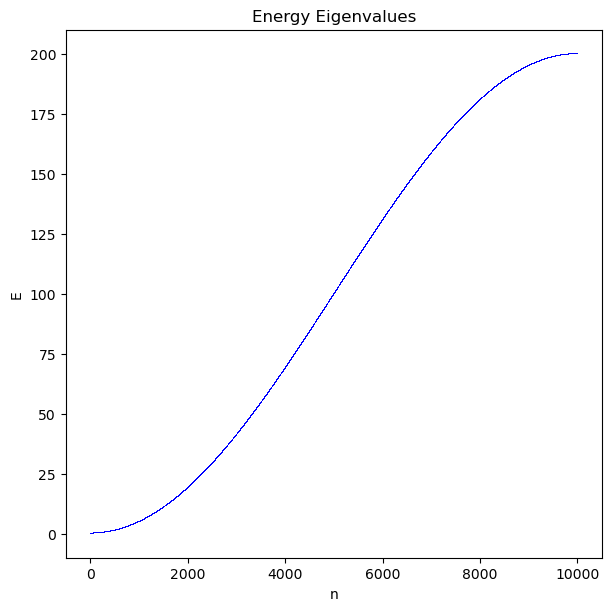

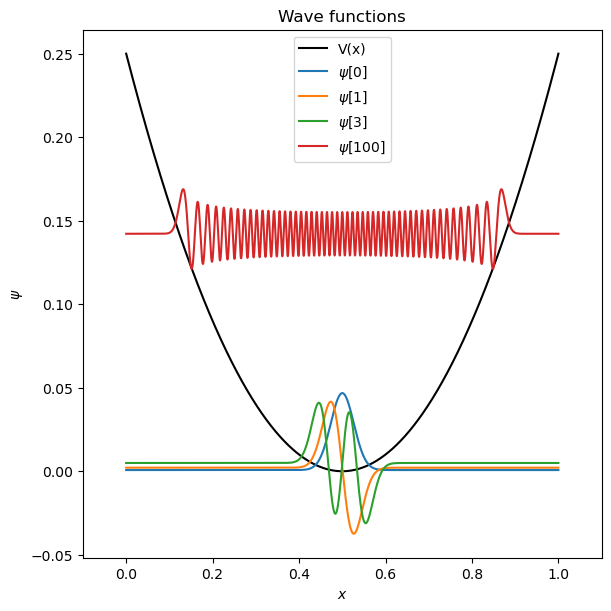

In [8]:
show_E(E)
show_psi(psi,E, [0,1,3, 100])

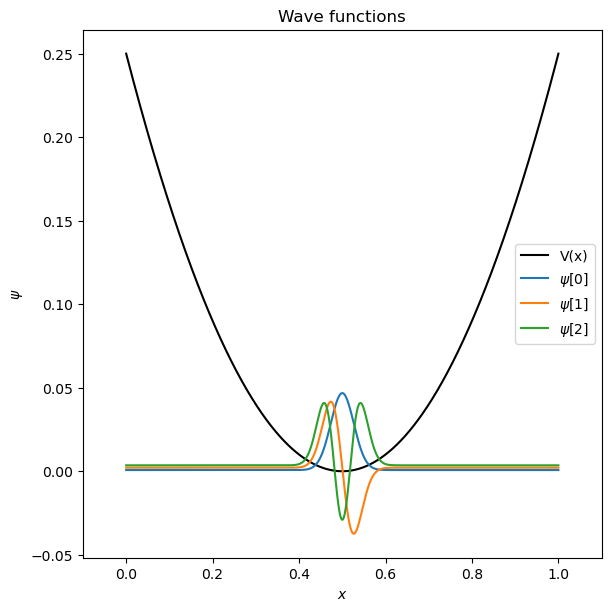

In [9]:
def plotting(funcs = [0, 1,2], size=(6,6), xrange=(0,1)):
    fig, ax = plt.subplots(figsize=size, layout='constrained')
    
    ax.plot(x, V(x,m,L)/(m*L**2), color= 'black', label='V(x)')
    
    for i in funcs:
        ax.plot(x ,psi[i] + E[i] , label = '$\psi$[' + str(i) + ']')
    
    ax.set_xlim(xrange[0]-0.1*(xrange[1]-xrange[0]),xrange[1]+0.1*(xrange[1]-xrange[0]))
    if xrange != (0,1):
        ax.set_ylim(-(max(psi[0])+E[0]),1.2*(max(psi[max(funcs)])+E[max(funcs)]))
    
    ax.set_xlabel('$x$')
    ax.set_ylabel('$\psi$')
    ax.set_title('Wave functions')
    ax.legend()

plotting()

Now that we have calculated the stationary states, I will animate their behavior over time by mulitplying the time dependent part $\phi_n(t)=e^{-i\frac{E_n}{\hbar}t}$ with the coresponding solution to the  time-independent Schrödinger Equation.

In [10]:
from matplotlib.animation import FuncAnimation
from IPython import display
from functools import partial

In [11]:
def anim_psi(i):
    fig = plt.figure()
    
    plt.title("Time dependent Eigenstate")
    plt.ylabel("$\Psi_n(x,t)$")
    plt.xlabel("x")

    lines = plt.plot([])
    line = lines[0]
    print(line)
    #setup
    plt.xlim(0,1)
    plt.ylim(-1.2*max(psi[i]),1.2*max(psi[i]))
    
    anim = FuncAnimation(fig, partial(animate_psi, psinr=i, plot=line), frames = 100, interval = 20)
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    
    plt.close()

In [12]:
#adjusted exponent to always show one period. This makes the result independent from the Energy of the Eigenstate.
def animate_psi(frame, psinr, plot):
    y = psi[psinr]*np.real(constants.e**(-complex(0,1)*frame/(100*2*pi)))
    plot.set_label(str(frame/100) + 'T')
    plot.set_data((x, y))
    plt.legend()

In [13]:
anim_psi(2)

Line2D(_child0)


## Linear combination of stationary states

Here I have to correct an inacurracy from above. What was calculated in the last step and shown in the animation is not technically $\Psi(x,t)$, but $\Psi_n(x,t)$ the soltion for one specific Energy. In the discrete case it can be shown, that the set of those solutions is complete and we can construct the most general solution $\Psi(x,t)$ by having some linear combination of all the stationary states.  
$\Psi(x,t)=\sum\limits_nc_n\Psi_n(x,t)$  
with  
$c_n=\langle\psi_n|\Psi(x,0)\rangle=\int\limits_{-\infty}^\infty \psi^*_n\Psi(x,0)dx$  
Given our first approximation of containing the wave function in between $x=0$ and $x=L$ this integral becomes numerically solvable.

In [14]:
def Psi0(x):
    return np.append(psi[0],np.zeros(3000))[3000:]

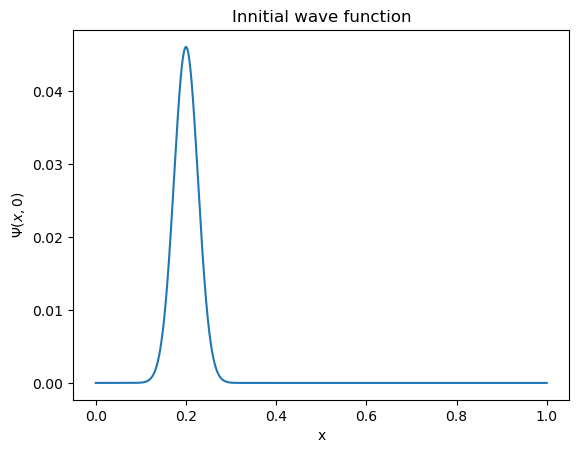

In [15]:
plt.plot(x,Psi0(x))
plt.title("Innitial wave function")
plt.ylabel("$\Psi(x,0)$")
plt.xlabel("x")
plt.show()

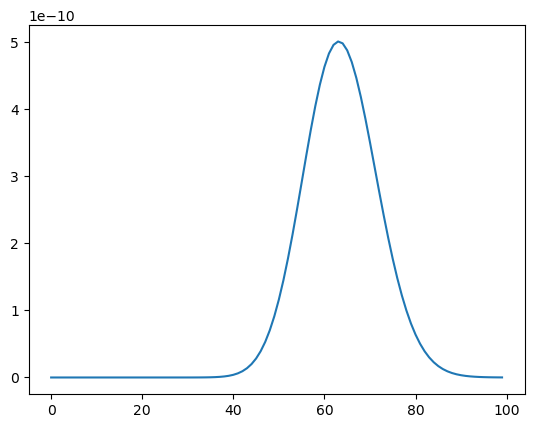

In [16]:
#calculating c
c = []
for i in range(100):
    c.append(np.trapz(np.multiply(Psi0(x), psi[i]), x))
plt.plot(np.abs(c)**2)

In [17]:
def c(N):
    c = []
    for i in range(N+1):
        c.append(np.trapz(np.multiply(Psi0(x), psi[i]), x))
    return c

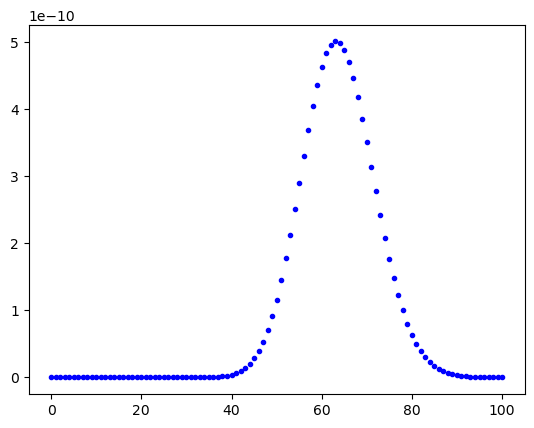

In [18]:
plt.plot(np.abs(c(100))**2, 'b.')
plt.show()

In [19]:
def lincomb(N, t):
    Psi=np.zeros(len(psi[0])).astype('complex128')
    for i in range(N+1):
        Psi += c(N)[i]*psi[i]*np.exp(-complex(0,1)*E[i]/E[1]*t)
    return Psi

C:\Users\User\Flo\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


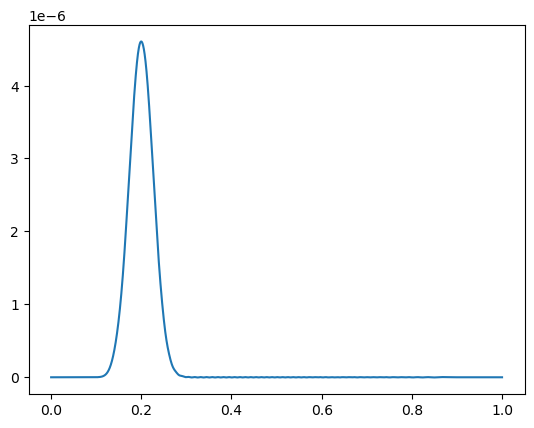

In [20]:
plt.plot(x, lincomb(100,0))

In [21]:
def animate_Psi(frame, N, plot):
    y = lincomb(N,frame/50)#np.abs(np.multiply(lincomb(N,frame/20),np.conjugate(lincomb(N,frame/50))))
    plot.set_data((x, y))

In [22]:
def anim_Psi(N, s):
    fig = plt.figure()

    lines = plt.plot([])
    line = lines[0]
    print(line)
    #setup
    plt.xlim(0,1)
    plt.ylim(-max(lincomb(N,0)),max(lincomb(N,0)))
    anim = FuncAnimation(fig, partial(animate_Psi, N=N, plot=line), frames = 50*s, interval = 20)
    video = anim.to_html5_video()
    html = display.HTML(video)
    display.display(html)
    plt.close()

In [26]:
anim_Psi(100,10)

Line2D(_child0)


C:\Users\User\Flo\Anaconda\lib\site-packages\matplotlib\transforms.py:2877: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])
C:\Users\User\Flo\Anaconda\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Appendix to generate image for describtion in the beginning.

In [24]:
def Image(save):
    x = np.linspace(0,1,1001)
    y = x*(1-x)
    plt.xlabel(r"$\xi$")
    plt.ylabel(r"$\psi$")
    plt.xticks([0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1], [r"$\xi_0$", "", "", "", r"$\xi_{i-1}$", r"$\xi_i$", r"$\xi_{i+1}$", "", "", "", r"$\xi_N$"])
    plt.yticks([])
    plt.plot(x, y)
    if save:
        plt.savefig(r'C:\Users\User\Downloads\discretization.png')

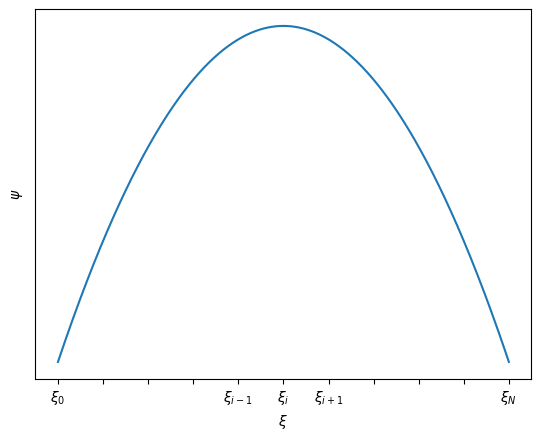

In [25]:
Image(False)